# Initial State Preparation

This notebook demonstrates how to prepare an initial quantum state using a the variational circuits defined in `ansatz.py`.

In [2]:
#imports
import numpy as np

from scipy.optimize import minimize

import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd().parent))

import matplotlib.pyplot as plt

from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit_aer import Aer

from src.ansatz import HEAnsatz
from src.utils import fidelity, gaussian_state

### 1D Gaussian

Target: $f(x) ∝ exp(-(x-0.5)²/(2σ²))$ with $σ=0.15$, normalized so that $||f||₂ = 1$.


------ Initial State Preparation ------

Optimal λ parameters: [ 3.12461641  1.34420817  1.30607331  1.7769838  -1.55136694 -0.26737572
 -0.65313557  1.44277626]

Final fidelity: 0.975084253374312


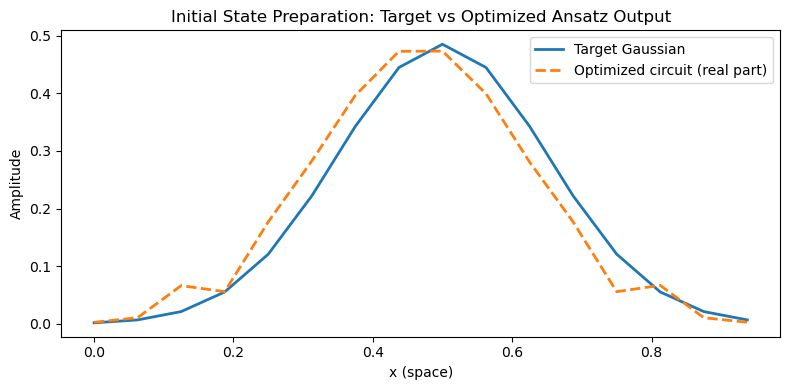

In [9]:
# --- Parameters ---
n_qubits = 4        # Number of qubits (grid size N = 2^n_qubits)
depth = 2           # Number of ansatz layers

# --- Target State: Normalized Gaussian ---
domain = [(0.0, 1.0)]  # 1D domain for the grid
target = gaussian_state(n_qubits, domain=domain)

# --- Ansatz and Initial Parameters ---
ansatz = HEAnsatz(n_qubits, depth)
init_params = ansatz.random_params()

# --- Optimize Parameters to Prepare the Target State ---
result = minimize(
    fidelity,
    init_params,
    args=(ansatz, target),
    method="COBYLA",
    options={"maxiter": 200}
)

optimal_params = result.x
final_fidelity = -result.fun

print("\n------ Initial State Preparation ------\n")
print("Optimal λ parameters:", optimal_params)
print("\nFinal fidelity:", final_fidelity)

# --- Get Optimized Statevector ---

qc = ansatz.qc(optimal_params)
backend = Aer.get_backend("statevector_simulator")
sv = Statevector.from_instruction(transpile(qc, backend))
psi_opt = sv.data  # complex amplitudes

# --- Plot Target vs. Optimized Ansatz Output ---
xs = np.linspace(domain[0][0], domain[0][1], 2**n_qubits, endpoint=False)

plt.figure(figsize=(8, 4))
plt.plot(xs, target, label="Target Gaussian", lw=2)
plt.plot(xs, np.real(psi_opt), label="Optimized circuit (real part)", lw=2, linestyle="--")
plt.xlabel("x (space)")
plt.ylabel("Amplitude")
plt.title("Initial State Preparation: Target vs Optimized Ansatz Output")
plt.legend()
plt.tight_layout()
plt.show()

### 2D Gaussian

Target: $f(x,y) ∝ exp(-((x-0.5)²+(y-0.5)²)/(2σ²))$ with $σ=0.15$, normalized so that $||f||₂ = 1$.


------ 2D Initial State Preparation ------

Optimal λ parameters: [-0.50073722  0.23917546  1.70746413 -1.12007585  0.37840475 -3.48272612
  4.27191654 -1.66960145]

Final fidelity: 0.9575944689872766


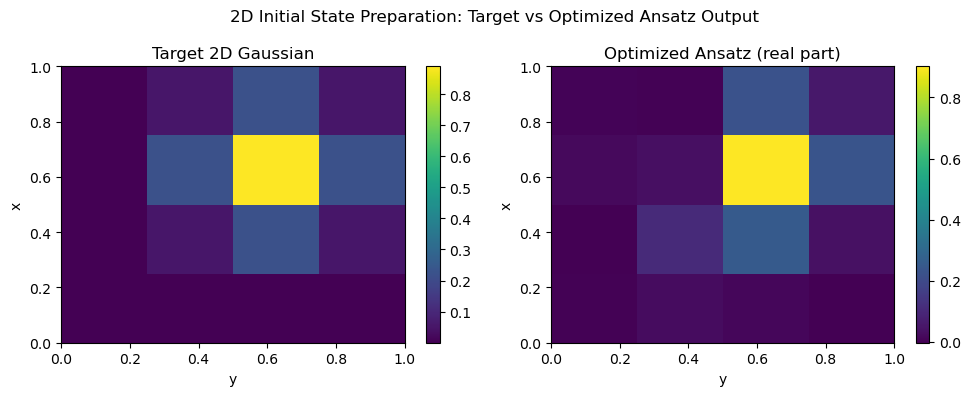

In [3]:
# --- Parameters ---
n_qubits = 4  # Must be even for 2D (e.g., 4 qubits => 4x4 grid)
depth = 2     # Number of ansatz layers

# --- Target State: Normalized 2D Gaussian ---
domain = [(0.0, 1.0), (0.0, 1.0)]  # 2D domain: [(xmin, xmax), (ymin, ymax)]
target = gaussian_state(n_qubits, domain=domain)

# --- Ansatz and Initial Parameters ---
ansatz = HEAnsatz(n_qubits, depth)
init_params = ansatz.random_params()

# --- Optimize Parameters to Prepare the Target State ---
result = minimize(
    fidelity,
    init_params,
    args=(ansatz, target),
    method="COBYLA",
    options={"maxiter": 200}
)

optimal_params = result.x
final_fidelity = -result.fun

print("\n------ 2D Initial State Preparation ------\n")
print("Optimal λ parameters:", optimal_params)
print("\nFinal fidelity:", final_fidelity)

# --- Get Optimized Statevector ---
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit_aer import Aer

qc = ansatz.qc(optimal_params)
backend = Aer.get_backend("statevector_simulator")
sv = Statevector.from_instruction(transpile(qc, backend))
psi_opt = sv.data  # complex amplitudes

# --- Plot Target vs. Optimized Ansatz Output (2D) ---
L = 2 ** n_qubits
n_side = int(np.sqrt(L))
(xmin, xmax), (ymin, ymax) = domain
xs = np.linspace(xmin, xmax, n_side, endpoint=False)
ys = np.linspace(ymin, ymax, n_side, endpoint=False)

# Reshape for 2D plotting
target_2d = target.reshape((n_side, n_side))
psi_opt_2d = np.real(psi_opt).reshape((n_side, n_side))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
im0 = axs[0].imshow(target_2d, extent=(xmin, xmax, ymin, ymax), origin='lower', aspect='auto')
axs[0].set_title("Target 2D Gaussian")
plt.colorbar(im0, ax=axs[0])
im1 = axs[1].imshow(psi_opt_2d, extent=(xmin, xmax, ymin, ymax), origin='lower', aspect='auto')
axs[1].set_title("Optimized Ansatz (real part)")
plt.colorbar(im1, ax=axs[1])
for ax in axs:
    ax.set_xlabel("y")
    ax.set_ylabel("x")
plt.suptitle("2D Initial State Preparation: Target vs Optimized Ansatz Output")
plt.tight_layout()
plt.show()